**Note:** if you want to run this notebook with all the data, we recommend to do that on a separate GPU (not on Colab) since **Colab does not run smoothly with the full dataset.**

**Tip:** you can increase the sample size until you understand how performance varies with the size of the sample. You can then use this knowledge to **experiment with a decent sample size and extrapolate your conclusions on the full dataset.**

## Setup

Before we start, we will select a GPU. 'Entorno de ejecución', 'Cambiar tipo de entrono de ejecución', 'Acelerador de hardware', '[GPU](https://medium.com/datadriveninvestor/comparing-gpu-and-tpu-training-performance-on-google-colaboratory-c1e54e26993f)'.

### Necessary libraries and paths

In [ ]:
from fastai.text import *
from fastai.callbacks import *
from sklearn.model_selection import train_test_split
from pathlib import Path
import pickle as pkl

If SAMPLE is 'True', the data will be a stratified 1% of the total training set. We will use SAMPLE = 'True' to be able to run all the notebook in a resonable amount of time.


El siguiente código crea directorios para guardar el modelo, y sample

In [ ]:
SAMPLE = True
PATH = Path('./sample') if SAMPLE else Path('.')
PATH.mkdir(exist_ok=True)

In [ ]:
MODELS_PATH = PATH / 'models'
MODELS_PATH.mkdir(exist_ok=True)

### Connect with Google Drive to download necessary files

In [ ]:
!pip install PyDrive

In [ ]:
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
!ls sample/models
!pwd


/content


### Download training and test set

In [ ]:
download = drive.CreateFile({'id': '1_Yh5w4DM18B4M17K0dG3xW5QELgksuP1'})
download.GetContentFile(PATH/'train.csv.gz')

In [ ]:
download = drive.CreateFile({'id': '1dqRTZA2a6Vnfw2E84hwMAkJK9SzMluql'})
download.GetContentFile(PATH/'test.csv')

In [ ]:
!mkdir models

In [ ]:
download = drive.CreateFile({'id': '1_0Kgr-2Hfywiaq4b-OE0YLblVnnv0QL_'})
download.GetContentFile(MODELS_PATH/'lm_enc.pth')

In [ ]:

download = drive.CreateFile({'id': '1SSZ01bjf8_8xLboEBP2AFGTG5vslMpX2'})
download.GetContentFile(PATH/'vocab_lm.pkl')

In [ ]:
PATH_TRAIN_COMP = PATH/'train.csv.gz'

In [ ]:
!gzip -d $PATH_TRAIN_COMP

## Preprocess training

We will remove caps since all of the words in Mercado Libre titles have caps so they are not useful. We will also remove accents since users sometimes write the words in a lazy way and the model would recognize two words (with and without accent) as different ones.

In [ ]:
import unicodedata
import pandas as pd

In [ ]:
def normalize_title(title):
    return unicodedata.normalize('NFKD', title.lower()).encode('ASCII', 'ignore').decode('utf8')

We will work with a **1% sample of the data** so that it runs swiftly. It is best practice to test with a small sample of the data before we run with all the data, to find errors.

We take a stratified sample which means that our sample keeps the distribution of number of observations per class. This is very useful when dealing with many, non-balanced classes and specially important given our evaluation metric (balanced accuracy).

In [ ]:
from sklearn.model_selection import train_test_split

if not (PATH / 'train_prepro.csv').exists() or True:
    df = pd.read_csv(PATH / 'train.csv')

    if SAMPLE:
        _, df = train_test_split(df, test_size=int(.03*len(df)), random_state=42, stratify=df.category)

    df['title'] = df.title.apply(normalize_title)
    df = df[~df.title.isna() & (df.title != 'nan') & (df.title != '')]

    df.to_csv(PATH / 'train_prepro.csv', index=False)

## Language Model

Transfer Learning is a technique by which by pre-training a model on a dataset, we can use the weights of this network as the starting point for training another, similar dataset.

To maximize the impact of transfer learning:
- The dataset with which we pre-train the model must be general enough to be able to serve as a starting point for many different problems/datasets

- The problem for which we pretrain must force the model to get a general understanding of the data (not too specific) so that it can be used for a number of downstream tasks

In NLP we generally train on a dataset such as Wikipedia (non domain-specific) and the problem is language modelling because it forces the model to have a general knowledge of the language in question.

### Language model databunch

In [1]:
if not (PATH / 'data_lm_export.pkl').exists():
    data_lm = TextLMDataBunch.from_csv(
        PATH, 'train_prepro.csv', text_cols='title', label_cols='category',
        valid_pct=0.05, max_vocab=100000, bs=64
    )


    data_lm.save('data_lm_export.pkl')
else:
    print('Loading databunch...')
    data_lm = load_data(PATH, 'data_lm_export.pkl')

NameError: ignored

### Language model training

The finetuning stage is important when we have a model, pre-trained on another corpus, and we need to 'warm-up' our model to out classification dataset.

We do this by running our classification data over our pre-trained language model a few times.

In [ ]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.05, pretrained=False)

# If finetuning an existing model
# learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.05, pretrained_fnames=('model_file', 'itos_file'))

In [ ]:
print('Finding learning rate...')
learn.lr_find()
learn.recorder.plot(skip_end=20, skip_start=40, suggestion=True)

In [ ]:
# If finetuning an existing model, we must first train the head
# learn.freeze()
# learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

In [ ]:
# If finetuning an existing model, we must then unfreeze the model and train it completely
# learn.unfreeze()

In [ ]:
learn.fit_one_cycle(
    10, 3e-3, callbacks=[SaveModelCallback(learn, every='epoch', monitor='accuracy', name='lm')]
)

In [ ]:
learn.save_encoder('lm_enc')
learn.save('lm')

## Classification

### Classification data

In [ ]:
df_smp = pd.read_csv(PATH / 'train_prepro.csv')

Now we create our 'databunch': an object that contains our datasets (train and validation) and our dataloaders. The dataloaders are iterables that we use to feed our model with batches of size 'batch_size'.

We must make sure that we use the same vocabulary (recongnized tokens) that we used in the language model. This will assure us that the model understands words and converts them to tokens in the same way.

In [ ]:
 with open(PATH/'vocab_lm.pkl', "rb") as input_file:
    lm_vocab = pkl.load(input_file)

In [ ]:
if not (PATH / 'data_clas_export.pkl').exists() or True:
    data_clas = TextClasDataBunch.from_csv(
        PATH,
        'train_prepro.csv',
        vocab=lm_vocab,
        bs=800,
        text_cols='title',
        label_cols='category'
    )

    data_clas.save('data_clas_export.pkl')
else:
    data_clas = load_data(PATH, 'data_clas_export.pkl')

In [ ]:
data_clas.show_batch(rows=10)

text,target
xxbos 100u tornillo tirafondo cabeza hexagonal zincado de 3 / 16 x 2 - 1 / 4 - para llave de 10 mm o 3 / 8 - hierro sae 1010,SCREWS
xxbos bateria para hp xxunk - 851 xxunk - 001 xxunk hstnn - xxunk hstnn - xxunk m volks xxunk tpn xxunk tpn xxunk tpn xxunk hp pavilion sl,LAPTOP_BATTERIES
xxbos jogo de chave biela l 10 pcs 8 - 9 - 10 - 11 - 12 - 13 -14 - 15 - 17 - 19 mm,WRENCH_SETS
"xxbos fresa de topo com haste cilindrica em aco rapido - varios cortes - ( hss ) - 12,00 mm - ref . 844 an rocast xxunk",TOOL_MILLS
xxbos kit pistao com aneis ybr 125 e - k - ed / xtz 125 e - k / factor 00 / ... ( std ),ENGINE_PISTONS
xxbos valvula presion turbo diverter peugeot 207 gti 308 5008 rcz 1.6 thp citroen ds3 c4 c5 1.6 thp mini 1.6 r55 r57 r58 r60,EGR_VALVES
xxbos switch gerenciavel 8 portas giga 10 / 100 / 100 + 2 p / mini - gbic sg 1002 mr l2 + intelbras,NETWORK_SWITCHES
xxbos tampa e rotor do honda civic 92 / 93 / 94 / 95 / 96 / 97 / 98 / 99 / 2,CAR_DISTRIBUTOR_CAPS
xxbos oculos feminino gatinho retro anos 50 60 e 70 vintage com lente olho de xxunk cat eye retro festa fantasia sexy gatinha,SUNGLASSES
xxbos base universal chica aliafor venturo gs - bu para punta guia y mecha sierra copa giro standard de 33 a 83 mm,DRILL_BITS


In [ ]:
data_clas.save('data_clas_smp.pkl')

In [ ]:
data_clas = load_data(PATH,'data_clas_smp.pkl')

FileNotFoundError: ignored

### Classifier training

In [ ]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.05 * (2 if SAMPLE else 1), bptt=12, path=PATH)
learn.load_encoder('lm_enc')
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.20E-01
Min loss divided by 10: 6.31E-02


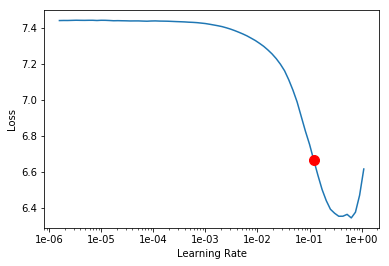

In [ ]:
learn.lr_find()
learn.recorder.plot(skip_end=10, skip_start=15, suggestion=True)

In [ ]:
learn.fit_one_cycle(1, 8e-2, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.460005,1.131086,0.773531,00:55


In [ ]:
learn.save('class_fit_head')

In [ ]:
learn.freeze_to(-2)

In [ ]:
# learn.lr_find()
# learn.recorder.plot(skip_end=20, skip_start=20, suggestion=True)

In [ ]:
learn.fit_one_cycle(1, slice(8e-4/(2.6**4), 8e-4), moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.214311,1.046207,0.791730,00:56


In [ ]:
learn.save('class_fit_top2')

In [ ]:
learn.load('class_fit_top2');

In [ ]:
learn.unfreeze()

In [ ]:
# learn.lr_find()
# learn.recorder.plot(skip_end=20, skip_start=20, suggestion=True)

In [ ]:
learn.fit_one_cycle(
    5, slice(3e-4/(2.6**4), 3e-4), moms=(0.8, 0.7),
    #callbacks=[SaveModelCallback(learn, every='epoch', monitor='accuracy', name='class_fit_full'), PrintingCallback()]
)

epoch,train_loss,valid_loss,accuracy,time
0,1.040357,0.999479,0.798480,02:34


KeyboardInterrupt: ignored

In [ ]:
learn.save('class_fit_full')

## Make submission

### Validation Balanced Accuracy

In [ ]:
from sklearn.metrics import balanced_accuracy_score

probs = learn.get_preds(ds_type=DatasetType.Valid)
pred_indices = torch.argmax(probs[0], dim=1)
preds_clas = [data_clas.classes[pred] for pred in pred_indices]

In [ ]:
true = [data_clas.classes[i] for i in probs[1].detach().numpy()]

Note: here we are calculating the balanced accuracy over both *reliable* and *unreliable* items, but the test set only contains *reliable* items.


In [ ]:
balanced_accuracy_score(true, preds_clas)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1745: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


0.7216212707142616

### Generate Submission

In [ ]:
df = pd.read_csv(PATH / 'test.csv')

In [ ]:
df['title'] = df.title.apply(normalize_title)
df.pop('language');
df.pop('id');

In [ ]:
df.head()

,title
0,kit maternidade bolsa-mala baby/bebe vinho men...
1,trocador de fraldas fisher price feminino rosa...
2,motor ventoinha - fiat idea / palio 1.8 - a 04...
3,amortecedor mola batente d dir new civic 14 - ...
4,cadeirinha de carro bebe princesa princess 9 a...


In [ ]:
learn.data.add_test(df, label=None)

In [ ]:
learn.data.show_batch(ds_type=DatasetType.Test, rows=10)

text,target
xxbos kit maternidade bolsa - mala baby / bebe vinho menina xxunk,3D_GLASSES
xxbos trocador de fraldas fisher price feminino rosa portatil,3D_GLASSES
xxbos motor ventoinha - fiat idea / palio 1.8 - a 0417 k,3D_GLASSES
xxbos amortecedor mola batente d dir new civic 14 - 7051 k,3D_GLASSES
xxbos cadeirinha de carro bebe princesa princess 9 a 36 kgs,3D_GLASSES
xxbos cabo freio mao tras direito vw up cod xxunk xxunk j,3D_GLASSES
xxbos mini pc dell optiplex fx160 atom 2 gb ram ssd 120 gb wifi,3D_GLASSES
xxbos kit bi xenon lampada h4 8000k,3D_GLASSES
xxbos protetor pe botinha - kickboxing karate taekwondo - competicao,3D_GLASSES
xxbos disco rigido externo western digital elements 1 tb usb3.0,3D_GLASSES


In [ ]:
probs = learn.get_preds(ds_type=DatasetType.Test)
pred_indices = torch.argmax(probs[0], dim=1)
preds_clas = [data_clas.classes[pred] for pred in pred_indices]

In [ ]:
learn.data.test_ds[10], preds_clas[10]

((Text xxbos picadora de carne fineschi legitima 32, EmptyLabel ),
 'MEAT_GRINDERS')

In [ ]:
learn.data.test_ds[100], preds_clas[100]

((Text xxbos gorras tycel para claritos sin perforar puro latex x12u .,
  EmptyLabel ),
 'HATS_AND_CAPS')

In [ ]:
learn.data.test_ds[1000], preds_clas[1000]

((Text xxbos cepillo pelo planchita alisador peine electrico, EmptyLabel ),
 'HAIR_STRAIGHTENING_BRUSHES')

In [ ]:
df = pd.read_csv(PATH / 'test.csv')
df.pop('language');
df.pop('title');
df['category'] = preds_clas

In [ ]:
df.head(5)

,id,category
0,0,DIAPER_BAGS
1,1,BABY_CHANGING_PADS
2,2,ENGINE_COOLING_FAN_MOTORS
3,3,GAS_LIFT_SUPPORTS
4,4,BABY_CAR_SEATS


In [ ]:
df.to_csv('submission.csv', index=False)

### Download Submission

In [ ]:
from google.colab import files
files.download('submission.csv')

## 87.5% is nice, but how can I do better?

💯**Run with full dataset**

* Just in case, don't forget you need to run the notebook with the full dataset to get full results!

❌ **Error analysis**

- What are the most frequent errors that the model makes?
- Can you find classes in which the model errs more than others?
- How can you help the model be more accurate in those classes?


📉 **Loss**


- What is the loss function that best correlates with the evaluation metric (balanced accuracy)?

📻**Noisy Labels**
- Labels are not 100% certain, are there ways for the model to avoid learning the noise? How can learning be different for *reliable* and *unreliable* items?



🆎**Text pre-processing**
- How can we help the model understand words better?
- How can we help the model associate similar meaning words?
- How can we help the model understand symbols and numbers so that they are useful for its objective?

🔧**Hyperparameters**
- Does increasing the vocabulary size improve perfomance?
- Can you tweak the learning rate, momentum or dropout multiplier to improve downstream performance?

🔨**New Model**
- Are there any other models that can improve our balanced accuracy, given the structure of the data and the problem type?

🆚**Two Languages**

* Does modelling the two languages separately improve performance?
* Does tokenizing languages with their individual tokenizers improve performance?

## References

* [AWD_LSTM](https://arxiv.org/pdf/1708.02182.pdf)
* [Transformer](https://arxiv.org/pdf/1706.03762.pdf) - [blog](https://medium.com/dissecting-bert/dissecting-bert-part-1-d3c3d495cdb3)
* [ULMFiT (transfer learning)](https://arxiv.org/pdf/1801.06146.pdf)
* [GPT](https://s3-us-west-2.amazonaws.com/openai-assets/research-covers/language-unsupervised/language_understanding_paper.pdf)
* [BERT](https://arxiv.org/pdf/1810.04805.pdf) - [blog](https://medium.com/dissecting-bert)
* [GPT2](https://d4mucfpksywv.cloudfront.net/better-language-models/language_models_are_unsupervised_multitask_learners.pdf) - [blog](https://medium.com/a-paper-a-day-will-have-you-screaming-hurray/day-1-language-models-are-unsupervised-multitask-learners-fdb7016d8aad)
* [TransfomerXL](https://arxiv.org/pdf/1901.02860.pdf) - [blog](https://medium.com/a-paper-a-day-will-have-you-screaming-hurray/day-9-transformer-xl-attentive-language-models-beyond-a-fixed-length-context-d045abf6db8)
* [fit_one_cycle](https://arxiv.org/pdf/1506.01186.pdf) - [blog](https://sgugger.github.io/the-1cycle-policy.html)
* [learning rate finder](https://arxiv.org/pdf/1803.09820.pdf) - [blog](https://sgugger.github.io/how-do-you-find-a-good-learning-rate.html)


* [TalkToTransformer](https://talktotransformer.com/)
* [fast.ai](https://www.fast.ai/)